# T-Insersection Autonomous Driving Scenario
This notebook demonstrates the a 3-player autonomous driving scenario. Three players are crossing a T-intersection and interact with each others. 


In [11]:
using ALGAMES
using BenchmarkTools
using LinearAlgebra
using StaticArrays
using TrajectoryOptimization
const TO = TrajectoryOptimization;

### Define the dynamics model of the game.

In [12]:
struct InertialUnicycleGame{T} <: AbstractGameModel
    n::Int  # Number of states
    m::Int  # Number of controls
    mp::T
    pu::Vector{Vector{Int}} # Indices of the each player's controls
    px::Vector{Vector{Int}} # Indices of the each player's x and y positions
    p::Int  # Number of players
end
InertialUnicycleGame() = InertialUnicycleGame(
    12,
    6,
    1.0,
    [[1,2],[3,4],[5,6]],
    [[1,2],[5,6],[9,10]],
    3)
Base.size(::InertialUnicycleGame) = 12,6,[[1,2],[3,4],[5,6]],3 # n,m,pu,p

### Instantiate dynamics model

In [13]:
model = InertialUnicycleGame()
n,m,pu,p = size(model)
T = Float64
px = model.px
function TO.dynamics(model::InertialUnicycleGame, x, u) # Non memory allocating dynamics
    qd1 = @SVector [cos(x[3]), sin(x[3])]
    qd1 *= x[4]
    qd2 = @SVector [cos(x[7]), sin(x[7])]
    qd2 *= x[8]
    qd3 = @SVector [cos(x[11]), sin(x[11])]
    qd3 *= x[12]
    qdd1 = u[ @SVector [1,2] ]
    qdd2 = u[ @SVector [3,4] ]
    qdd3 = u[ @SVector [5,6] ]
    return [qd1; qdd1; qd2; qdd2; qd3; qdd3]
end;

### Discretization of the trajectories

In [14]:
tf = 3.0  # final time
N = 41    # number of knot points
dt = tf / (N-1); # time step duration

### Initial and final state definition

In [15]:
# Define initial and final states (be sure to use Static Vectors!)
x0 = @SVector [ # Initial state
              -0.50,  -0.15,  0.00,  0.60, #player 1 x,y,θ,v
               1.40,   0.15,  pi,    0.60, #player 2 x,y,θ,v
               0.43,  -0.30,  pi/2,  0.12, #player 3 x,y,θ,v
                ]
xf = @SVector [ # Final State
               1.30,  -0.15,  0.00, 0.60, #player 1 x,y,θ,v
              -0.30,   0.15,  pi,   0.60, #player 2 x,y,θ,v
               0.43,   0.35,  pi/2, 0.30, #player 3 x,y,θ,v
               ];

### Define players objective functions

In [22]:
# Define quadratic costs
diag_Q1 = @SVector [ # Player 1 state cost
    0., 1., 1., 1.,
    0., 0., 0., 0.,
    0., 0., 0., 0.]
diag_Q2 = @SVector [ # Player 2 state cost
    0., 0., 0., 0.,
    0., 1., 1., 1.,
    0., 0., 0., 0.]
diag_Q3 = @SVector [ # Player 3 state cost
    0., 0., 0., 0.,
    0., 0., 0., 0.,
    0., 1., 1., 1.]

# Players stage state costs
Q = [0.1*Diagonal(diag_Q1), 
     0.1*Diagonal(diag_Q2),
     0.1*Diagonal(diag_Q3)]

# Players final state costs
Qf = [1.0*Diagonal(diag_Q1),
      1.0*Diagonal(diag_Q2),
      1.0*Diagonal(diag_Q3)]

# Players controls costs
R = [0.1*Diagonal(@SVector ones(length(pu[1]))),
     0.1*Diagonal(@SVector ones(length(pu[2]))),
     0.1*Diagonal(@SVector ones(length(pu[3]))),
    ]

# Players objectives
obj = [LQRObjective(Q[i],R[i],Qf[i],xf,N) for i=1:p];

### Define the initial trajectory

In [23]:
xs = SVector{n}(zeros(n))
us = SVector{m}(zeros(m))
Z = [KnotPoint(xs,us,dt) for k = 1:N]
Z[end] = KnotPoint(xs,m);

### Build the T-intersection scenario

In [30]:
# Actors 
car_radius = 0.08
car_radii = [car_radius for i=1:p]
actors_types = [:car, :car, :pedestrian] # For visualization

#Scene
top_road_length = 4.0
road_width = 0.60
bottom_road_length = 1.0
cross_width = 0.25
bound_radius = 0.05
# Lane indices for each player
# Each lane defines a specific drivable area 
lanes = [1, 2, 5]

# Build scenario
scenario = TIntersectionScenario(
    top_road_length, road_width, bottom_road_length,
    cross_width, car_radii, actors_types, bound_radius);

### Define constraints of the problem

In [31]:
# Create constraint sets
conSet = ConstraintSet(n,m,N)
con_inds = 2:N # Indices where the constraints will be applied

# Add collision avoidance constraints
add_collision_avoidance(conSet, car_radii, px, p, con_inds)

# Add scenario specific constraints (road boundaries)
add_scenario_constraints(conSet, scenario, lanes, px, con_inds; constraint_type=:constraint);

### Define the problem we will be solving

In [38]:
prob = GameProblem(model, obj, conSet, x0, xf, Z, N, tf);

### Build the ALGAMES solver 

In [44]:
opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10)
solver = DirectGamesSolver(prob, opts);

### Solve the problem

In [45]:
@time solve!(solver);

Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
  0.060016 seconds (20.78 k allocations: 14.442 MiB)


### Evaluate the solve time

In [51]:
@btime timing_solve(solver_directgames);

Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iterat

outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & c

outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
Solver iteration = 1
Solver iteration = 2
Solver iteration = 3
Solver iteration = 4
outer converged cost_tolerance & constraint_tolerance
  54.081 ms (22652 allocations: 14.23 MiB)


### Visualize state and control trajectories

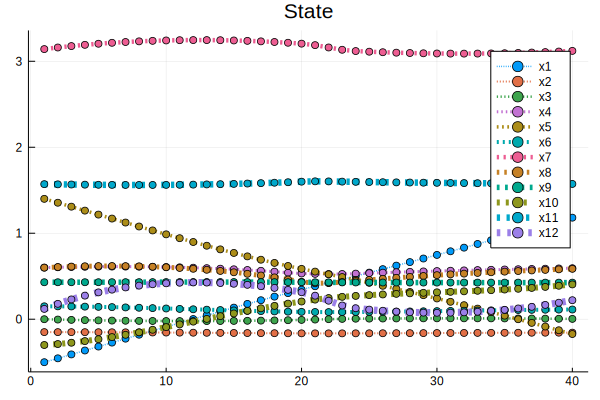

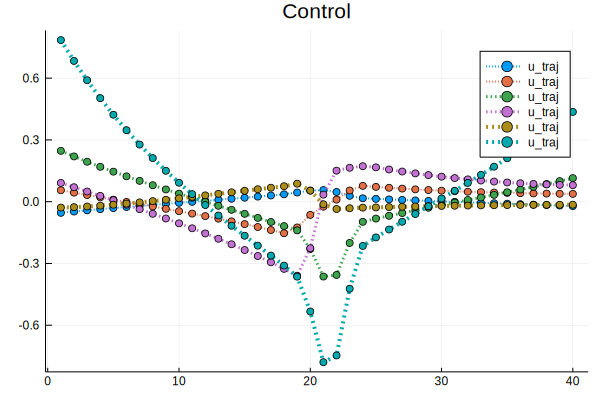

In [53]:
X = TO.states(solver)
U = TO.controls(solver)
visualize_state(X)
visualize_control(U,pu)

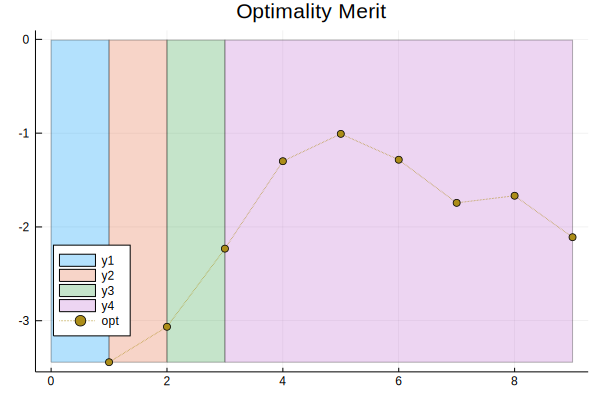

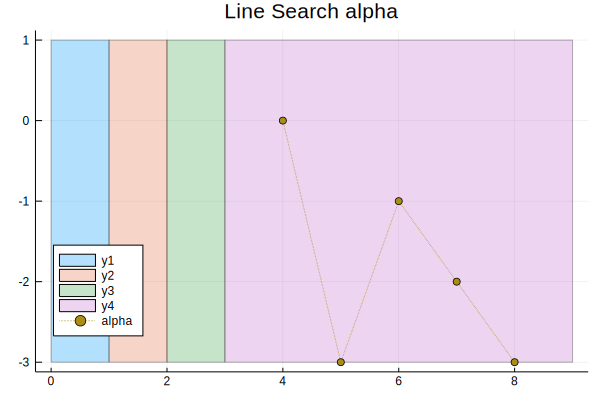

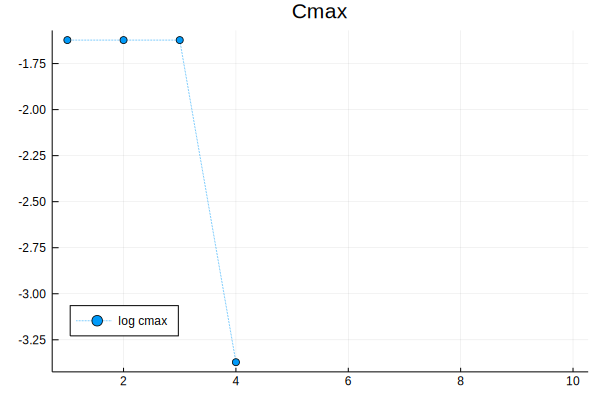

In [54]:
visualize_optimality_merit(solver)
visualize_α(solver)
visualize_cmax(solver)

In [55]:
### Create a 3D visualization in MeshCat

In [63]:
vis=ALGAMES.Visualizer()
anim=ALGAMES.MeshCat.Animation()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8741
└ @ MeshCat /home/simon/.julia/packages/MeshCat/nXUuG/src/visualizer.jl:69


MeshCat.Animation(Dict{MeshCat.SceneTrees.Path,MeshCat.AnimationClip}(), 30)

In [64]:
ALGAMES.MeshCat.render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), Dict{String,MeshCat.SceneTrees.SceneNode}()), Set(Any[]), ip"127.0.0.1", 8741))

In [69]:
vis, anim = animation(solver_directgames, scenario;
    vis=vis, anim=anim,
    open_vis=false);